# Monte Carlo Simulations to predict prices of stock indices

- We use historical data from financial markets and run Monte Carlo simulations to predict prices of stock indices.\
We have chosen to use NIFTY 50, NIFTY 100, NIFTY 200, NIFTY 500, NIFTY Next 50 and BSE 500 indices.

- In the Indian stock market, these are benchmark stock market indices that represent the weighted average of some of the largest Indian companies listed on the National Stock Exchange (or Bombay stock exchange).\
This is not to be confused with the informal designation "Nifty Fifty" of some of the large-cap stocks on the New York Stock Exchange. 

- There is nothing specific about these stock indices (as opposed to other stock prices) that we use in this project.\
We could do this for other indices or individual stocks.

- We run Monte Carlo simulations $N$ times and predict the stock prices $n$ days in the future from last available historical data.\
The values of $N$, $n$ have been initialized below and can be adjusted.

- We use historical data until the last Friday in August 2024 (which is Aug 30, 2024).\
Replacing the HistoricalData_*.csv files as more data becomes available will make the predictions more accurate.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns;sns.set()
import warnings

rng = np.random.default_rng() #For generating random numbers from normal distribution
N = 100*1000 #Number of iterations for Monte Carlo simulations
n = 30 #Number of days in the future for which we want to predict the prices
T = 252 #Number of trading days in a year

- We import the historical data (in the form of csv files) and plot the graphs of the values over time.\
The csv files have columns: Index Name, Date, Open, High, Low, Close\
We use data from 1990 to 2024.

- Base period for NIFTY 50 is 3 November, 1995 with base value 1000.\
Base period for NIFTY 100 is January, 2003 with base value 1000.\
Base period for NIFTY 200 is 1 January, 2004 with base value 1000.\
Base period for NIFTY 500 is 3 November, 1995 with base value 1000.\
Base period for NIFTY Next 50 is 1 January, 1995 with base value 1000.\
Base period for BSE 500 is August, 1999 with base value 1000.

- In a year, we have approximately $252$ trading days which is why we have initialized $T$ above to $252$.\
We take a year to have $365$ days and if we subtract $2$ days for the weekend for each of the $52$ weeks, we get $365 - 2\times52 = 365 - 104 = 261$.\
Accounting for stock market being closed on holidays, we have roughly $252$ trading days, each year.

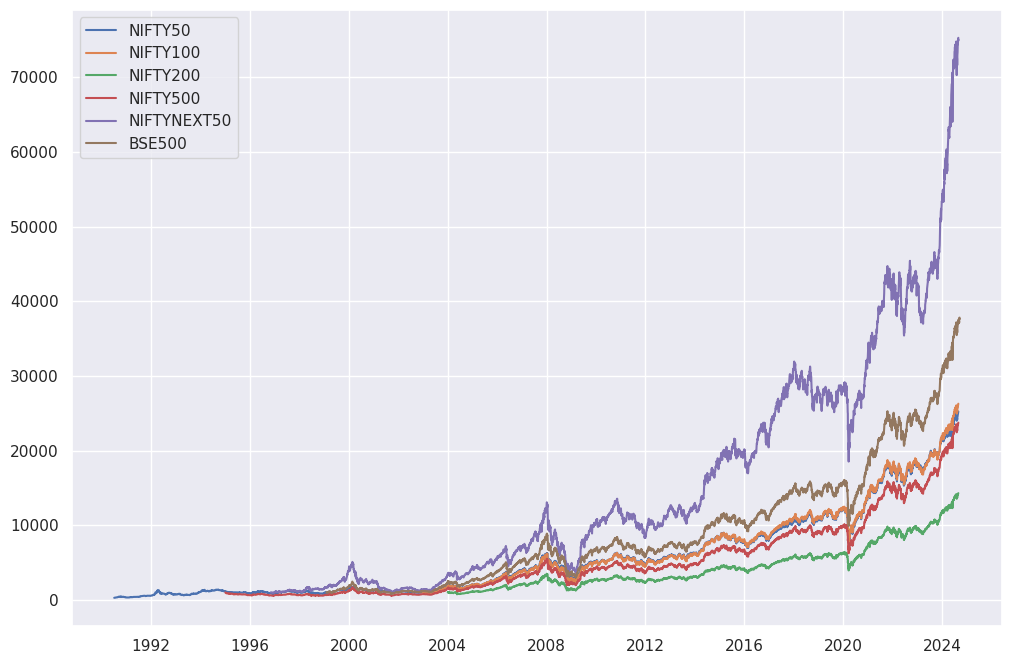

In [2]:
df50 = pd.read_csv('HistoricalData_Nifty50.csv')
df50.Date = pd.to_datetime(df50.Date)

df100 = pd.read_csv('HistoricalData_Nifty100.csv')
df100.Date = pd.to_datetime(df100.Date)

df200 = pd.read_csv('HistoricalData_Nifty200.csv')
df200.Date = pd.to_datetime(df200.Date)

df500 = pd.read_csv('HistoricalData_Nifty500.csv')
df500.Date = pd.to_datetime(df500.Date)

dfn50 = pd.read_csv('HistoricalData_NiftyNext50.csv')
dfn50.Date = pd.to_datetime(dfn50.Date)

dfb500 = pd.read_csv('HistoricalData_BSE500.csv')
dfb500.Date = pd.to_datetime(dfb500.Date)

plt.figure(figsize=(12, 8))
plt.plot_date(df50.Date, df50.Close, fmt='-', label = 'NIFTY50');
plt.plot_date(df100.Date, df100.Close, fmt='-', label = 'NIFTY100');
plt.plot_date(df200.Date, df200.Close, fmt='-', label = 'NIFTY200');
plt.plot_date(df500.Date, df500.Close, fmt='-', label = 'NIFTY500');
plt.plot_date(dfn50.Date, dfn50.Close, fmt='-', label = 'NIFTYNEXT50');
plt.plot_date(dfb500.Date, dfb500.Close, fmt='-', label = 'BSE500');
plt.legend();

# Geometric Brownian Motion

- In the Stochastic process usually assumed for the price of a stock, we have
$$dS = \mu Sdt + \sigma Sdz$$
This is known as Geometric Brownian motion where S denotes the stock price, $\mu$ is the expected rate of return per unit of time from the stock and $\sigma$ is the volatility of the stock price. The term $dz$ is referred to as a Weiner process.

- The discrete-time version of this model is given by
$$\Delta S = \mu S\Delta t + \sigma S\epsilon\sqrt\Delta t$$

**Remarks about implementation**
- In the above formula, we have $\epsilon$ to be normally distributed which we randomly sample.\
We have $\Delta t = 1$ because we go in 1-day increments.

- We calculate $\mu$ as the mean of the returns from existing data.\
(Finer points about this calculation discussed below)

- We calculate $\sigma$ as the standard deviation from existing data.\
(Finer points about this calculation discussed below)

In [3]:
df50['PercentChange'] = df50['Close'].pct_change()
df50['LogReturn'] = np.log(df50['Close'] / df50['Close'].shift(1))
df50['AltLogReturn'] = np.log(1+df50['Close'].pct_change())

df100['PercentChange'] = df100['Close'].pct_change()
df100['LogReturn'] = np.log(df100['Close'] / df100['Close'].shift(1))
df100['AltLogReturn'] = np.log(1+df100['Close'].pct_change())

df200['PercentChange'] = df200['Close'].pct_change()
df200['LogReturn'] = np.log(df200['Close'] / df200['Close'].shift(1))
df200['AltLogReturn'] = np.log(1+df200['Close'].pct_change())

df500['PercentChange'] = df500['Close'].pct_change()
df500['LogReturn'] = np.log(df500['Close'] / df500['Close'].shift(1))
df500['AltLogReturn'] = np.log(1+df500['Close'].pct_change())

dfn50['PercentChange'] = dfn50['Close'].pct_change()
dfn50['LogReturn'] = np.log(dfn50['Close'] / dfn50['Close'].shift(1))
dfn50['AltLogReturn'] = np.log(1+dfn50['Close'].pct_change())

dfb500['PercentChange'] = dfb500['Close'].pct_change()
dfb500['LogReturn'] = np.log(dfb500['Close'] / dfb500['Close'].shift(1))
dfb500['AltLogReturn'] = np.log(1+dfb500['Close'].pct_change())

- We have added three new columns to our data frames which calculate the Percentage Change, Log Return, and an Alternative to Log Return.

- Let $S_i$ denote the price on day $i$.\
The percentage change is given by
$$\frac{\Delta S}{S} = \frac{S_i-S_{i-1}}{S_{i-1}}$$
The daily log return is given by
$$\Delta(\ln S) = \ln(S_i)-\ln(S_{i-1}) = \ln\left(\frac{S_i}{S_{i-1}}\right)$$
Observe that we have the following equality
$$\ln(1+\frac{\Delta S}{S}) = \ln(1 + \frac{S_i - S_{i-1}}{S_{i-1}}) = \ln\left(\frac{S_i}{S_{i-1}}\right) = \Delta(\ln S)$$
The three new columns we have added are $\frac{\Delta S}{S}, \Delta(\ln S), \ln(1+\frac{\Delta S}{S})$ and the equation above says that the last two of these three entries are always the same.

- By $It\hat{o}'s$ lemma, the daily log return is normally distributed and its mean is called the *drift* of the security which is equal to $\mu-\frac{1}{2}\sigma^2$.\
Thus, we have the mean (or expected values) as
$$\mathbf{E}\left(\frac{\Delta S}{S}\right) = \mu$$
$$\mathbf{E}(\Delta(\ln S)) = \mu-\frac{1}{2}\sigma^2$$
$$\mathbf{E}\left(\ln(1+\frac{\Delta S}{S})\right) = \mu-\frac{1}{2}\sigma^2$$

- The standard deviation of all of these three quantities is $\sigma$.

In [4]:
df50.tail() #The last few rows of the data frame for Nifty 50.

,Index Name,Date,Open,High,Low,Close,PercentChange,LogReturn,AltLogReturn
8291,NIFTY 50,2024-08-26,24906.1,25043.8,24874.7,25010.60,0.007551,0.007523,0.007523
8292,NIFTY 50,2024-08-27,25024.8,25073.1,24973.65,25017.75,0.000286,0.000286,0.000286
8293,NIFTY 50,2024-08-28,25030.8,25129.6,24964.65,25052.35,0.001383,0.001382,0.001382
8294,NIFTY 50,2024-08-29,25035.3,25192.9,24998.5,25151.95,0.003976,0.003968,0.003968
8295,NIFTY 50,2024-08-30,25249.7,25268.35,25199.4,25235.90,0.003338,0.003332,0.003332


- We denote by $\mu_1, \mu_2, \mu_3$ the means of $\frac{\Delta S}{S}, \Delta(\ln S), \ln(1+\frac{\Delta S}{S})$ respectively.\
We calculate the annualized rate of return by multiplying by the number of trading days in a year.

- We denote by $\sigma_1, \sigma_2, \sigma_3$ the volatilities (standard deviations) of $\frac{\Delta S}{S}, \Delta(\ln S), \ln(1+\frac{\Delta S}{S})$.\
We calculate the annualized volatilities similarly.\
Since there is no difference between $\Delta(\ln S)$ and $\ln(1+\frac{\Delta S}{S})$, we don't use the last column for future calculations.

- We check that $\mu_1 - \frac{1}{2}\sigma_1^2 = \mu_2$.\
We also check that we get the same annualized volatilities by measuring the standard deviations of the three quantities.\
We do all of this for NIFTY 50 and it can be calculated for the other indices.

In [5]:
mu1 = df50.PercentChange.mean()
mu2 = df50.LogReturn.mean()
mu3 = df50.AltLogReturn.mean()

v1 = df50.PercentChange.var()
v2 = df50.LogReturn.var()
v3 = df50.AltLogReturn.var()

v1_ann = v1*T
v2_ann = v2*T
v3_ann = v3*T

s1 = df50.PercentChange.std()
s2 = df50.LogReturn.std()
s3 = df50.AltLogReturn.std()

s1_ann = np.sqrt(v1_ann)
s2_ann = np.sqrt(v2_ann)
s3_ann = np.sqrt(v3_ann)

print("Annualized expected rate of return given by \mu_1*T:",mu1*T)
print("Annualized expected rate of return given by \mu_2*T:",mu2*T)
print("Annualized expected rate of return given by \mu_3*T:",mu3*T)
print("")
print("The drift given by \mu_1*T - ((\sigma_1)^2*T)/2    :",mu1*T-v1_ann/2)
print("")
print("Annualized Volatility (calculated from Percent Change):",s1_ann)
print("Annualized Volatility (calculated from Log Return)    :",s2_ann)
print("Annualized Volatility (calculated from Alt Log Return):",s3_ann)

Annualized expected rate of return given by \mu_1*T: 0.16708845062854766
Annualized expected rate of return given by \mu_2*T: 0.136852842502778
Annualized expected rate of return given by \mu_3*T: 0.136852842502778

The drift given by \mu_1*T - ((\sigma_1)^2*T)/2    : 0.13689327512004354

Annualized Volatility (calculated from Percent Change): 0.2457444831873307
Annualized Volatility (calculated from Log Return)    : 0.2458077287830703
Annualized Volatility (calculated from Alt Log Return): 0.2458077287830703


The above calculations say that the expected return of NIFTY 50 is about 16.7% per year with an annualized volatility of about 24.6%.

To perform Monte Carlo simulations and predict prices in the future, we make a a few observations and assumptions.

- We do not need the volatility for the entire historical data.
- We only need the volatility of the stock prices on the current day.
- Volatility estimation can be done in a number of ways (eg: EWMA, ARCH, GARCH) which are interesting on their own.
- We instead do a rolling volatility calculation on the previous $n$ days.
- This makes it a maximum likelihood estimate instead of an unbiased estimate but it simplifies calculations.
- The expected change in a variable is very small when compared with the standard deviation of changes.
- So, we assume that the mean of the daily log return over the previous $n$ days is 0.

,Index Name,Date,Open,High,Low,Close,PercentChange,LogReturn,AltLogReturn,Variance,Volatility
8291,NIFTY 50,2024-08-26,24906.1,25043.8,24874.7,25010.60,0.007551,0.007523,0.007523,5.659627e-05,0.008610
8292,NIFTY 50,2024-08-27,25024.8,25073.1,24973.65,25017.75,0.000286,0.000286,0.000286,8.170332e-08,0.008497
8293,NIFTY 50,2024-08-28,25030.8,25129.6,24964.65,25052.35,0.001383,0.001382,0.001382,1.910097e-06,0.008477
8294,NIFTY 50,2024-08-29,25035.3,25192.9,24998.5,25151.95,0.003976,0.003968,0.003968,1.574338e-05,0.008506
8295,NIFTY 50,2024-08-30,25249.7,25268.35,25199.4,25235.90,0.003338,0.003332,0.003332,1.110326e-05,0.008414


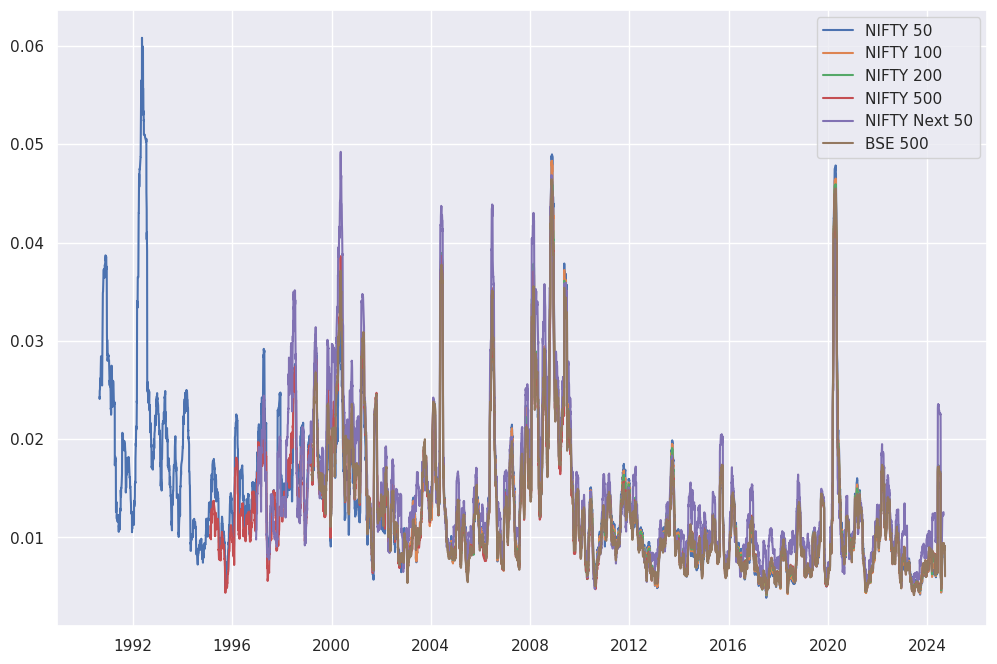

In [6]:
df50['Variance'] = df50.LogReturn**2
df50['Volatility'] = np.sqrt(df50.Variance.rolling(n).mean())

df100['Variance'] = df100.LogReturn**2
df100['Volatility'] = np.sqrt(df100.Variance.rolling(n).mean())

df200['Variance'] = df200.LogReturn**2
df200['Volatility'] = np.sqrt(df200.Variance.rolling(n).mean())

df500['Variance'] = df500.LogReturn**2
df500['Volatility'] = np.sqrt(df500.Variance.rolling(n).mean())

dfn50['Variance'] = dfn50.LogReturn**2
dfn50['Volatility'] = np.sqrt(dfn50.Variance.rolling(n).mean())

dfb500['Variance'] = dfb500.LogReturn**2
dfb500['Volatility'] = np.sqrt(dfb500.Variance.rolling(n).mean())

plt.figure(figsize=(12, 8))
plt.plot_date(df50.Date, df50.Volatility, fmt='-', label='NIFTY 50');
plt.plot_date(df100.Date, df100.Volatility, fmt='-', label='NIFTY 100');
plt.plot_date(df200.Date, df200.Volatility, fmt='-', label='NIFTY 200');
plt.plot_date(df500.Date, df500.Volatility, fmt='-', label='NIFTY 500');
plt.plot_date(dfn50.Date, dfn50.Volatility, fmt='-', label='NIFTY Next 50');
plt.plot_date(dfb500.Date, dfb500.Volatility, fmt='-', label='BSE 500');
plt.legend()

df50.tail() #To show how the tail of current NIFTY 50 data frame looks like

In [7]:
print("Rolling computation of the mean over the last n days:   ",df50.PercentChange.rolling(n).mean().iloc[-1])
print("Expected rate of return given by \mu_1 calculated above:",mu1)

Rolling computation of the mean over the last n days:    0.0006149956777022866
Expected rate of return given by \mu_1 calculated above: 0.0006630494072561415


We generally assume the parameter $\mu$ to be a constant and here (as a check) we see that the rolling mean over the last $n$ days is roughly constant and equal to the value of $\mu$ that we have computed earlier.

# NIFTY 50

We run Monte Carlo Simulation for NIFTY 50.

In [29]:
mu = df50.PercentChange.mean()
s = df50["Volatility"].iloc[-1]
avg = [0]*(n)
price = []
for i in range(N):
    normals = rng.normal(size=n)
    prev_price = df50['Close'].iloc[-1]
    for j in range(n):
        p = prev_price + mu*prev_price + s*normals[j]*prev_price
        avg[j] = (avg[j]*i+p)/(i+1)
        prev_price = p
    price.append(prev_price)
print("Expected price of NIFTY 50 after",n,"trading days from Aug 30, 2024:",avg[-1])

Expected price of NIFTY 50 after 30 trading days from Aug 30, 2024: 25743.89653721313


We plot the histogram of the distribution of prices of NIFTY 50 as predicted by Monte Carlo simulation after $n$ days.

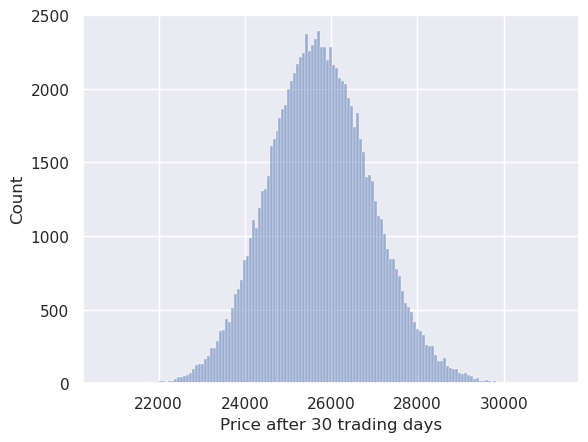

In [30]:
sns.histplot(pd.DataFrame(price),legend=False)
plt.xlabel("Price after "+str(n)+" trading days");
warnings.filterwarnings('ignore')

We plot the expected price of NIFTY 50 over the next $n$ days as predicted by Monte Carlo simulation.

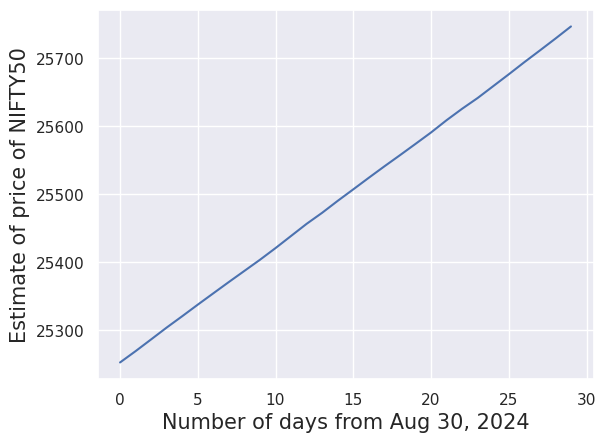

In [10]:
plt.plot(list(range(n)),avg)
plt.xlabel('Number of days from Aug 30, 2024', fontsize = 15)
plt.ylabel('Estimate of price of NIFTY50', fontsize = 15)
plt.show()

# NIFTY 100

We run Monte Carlo Simulation for NIFTY 100.

In [11]:
mu = df100.PercentChange.mean()
s = df100["Volatility"].iloc[-1]
avg = [0]*(n)
price = []
for i in range(N):
    normals = rng.normal(size=n)
    prev_price = df100['Close'].iloc[-1]
    for j in range(n):
        p = prev_price + mu*prev_price + s*normals[j]*prev_price
        avg[j] = (avg[j]*i+p)/(i+1)
        prev_price = p
    price.append(prev_price)
print("Expected price of NIFTY 100 after",n,"trading days from Aug 30, 2024:",avg[-1])

Expected price of NIFTY 100 after 30 trading days from Aug 30, 2024: 26837.290468579176


We plot the histogram of the distribution of prices of NIFTY 100 as predicted by Monte Carlo simulation after $n$ days.

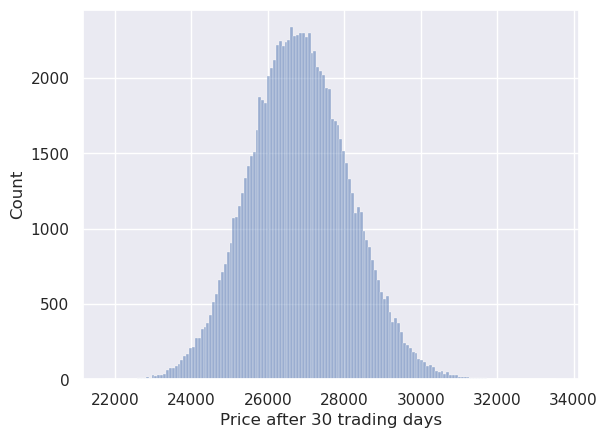

In [12]:
sns.histplot(pd.DataFrame(price),legend=False)
plt.xlabel("Price after "+str(n)+" trading days");
warnings.filterwarnings('ignore')

We plot the expected price of NIFTY 100 over the next $n$ days as predicted by Monte Carlo simulation.

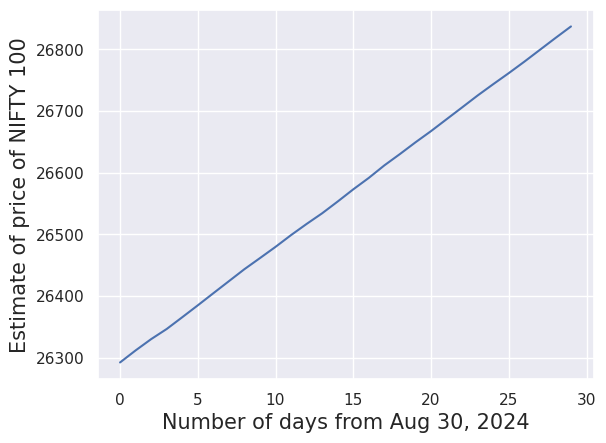

In [13]:
plt.plot(list(range(n)),avg)
plt.xlabel('Number of days from Aug 30, 2024', fontsize = 15)
plt.ylabel('Estimate of price of NIFTY 100', fontsize = 15)
plt.show()

# NIFTY 200

We run Monte Carlo Simulation for NIFTY 200.

In [14]:
mu = df200.PercentChange.mean()
s = df200["Volatility"].iloc[-1]
avg = [0]*(n)
price = []
for i in range(N):
    normals = rng.normal(size=n)
    prev_price = df200['Close'].iloc[-1]
    for j in range(n):
        p = prev_price + mu*prev_price + s*normals[j]*prev_price
        avg[j] = (avg[j]*i+p)/(i+1)
        prev_price = p
    price.append(prev_price)
print("Expected price of NIFTY 200 after",n,"trading days from Aug 30, 2024:",avg[-1])

Expected price of NIFTY 200 after 30 trading days from Aug 30, 2024: 14560.942654907356


We plot the histogram of the distribution of prices of NIFTY 200 as predicted by Monte Carlo simulation after $n$ days.

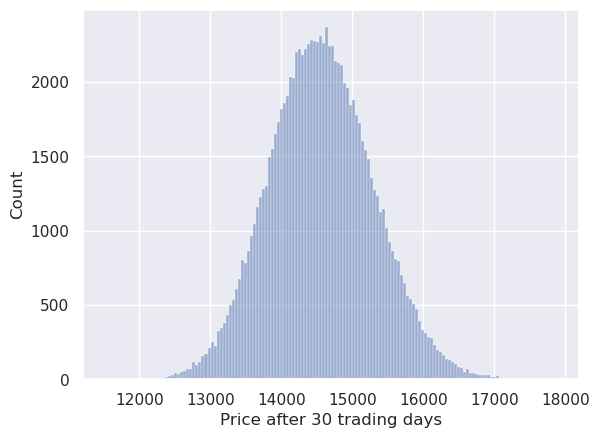

In [15]:
sns.histplot(pd.DataFrame(price),legend=False)
plt.xlabel("Price after "+str(n)+" trading days");
warnings.filterwarnings('ignore')

We plot the expected price of NIFTY 200 over the next $n$ days as predicted by Monte Carlo simulation.

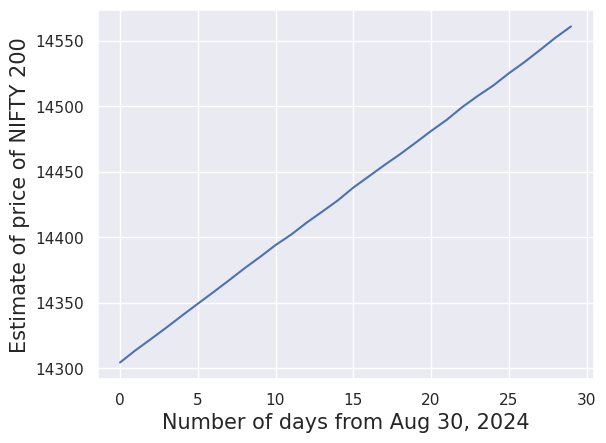

In [16]:
plt.plot(list(range(n)),avg)
plt.xlabel('Number of days from Aug 30, 2024', fontsize = 15)
plt.ylabel('Estimate of price of NIFTY 200', fontsize = 15)
plt.show()

# NIFTY 500

We run Monte Carlo Simulation for NIFTY 500.

In [17]:
mu = df500.PercentChange.mean()
s = df500["Volatility"].iloc[-1]
avg = [0]*(n)
price = []
for i in range(N):
    normals = rng.normal(size=n)
    prev_price = df500['Close'].iloc[-1]
    for j in range(n):
        p = prev_price + mu*prev_price + s*normals[j]*prev_price
        avg[j] = (avg[j]*i+p)/(i+1)
        prev_price = p
    price.append(prev_price)
print("Expected price of NIFTY 500 after",n,"trading days from Aug 30, 2024:",avg[-1])

Expected price of NIFTY 500 after 30 trading days from Aug 30, 2024: 24114.03556697075


We plot the histogram of the distribution of prices of NIFTY 200 as predicted by Monte Carlo simulation after $n$ days.

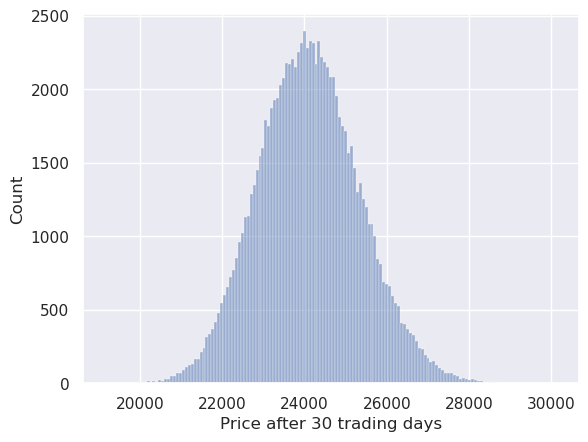

In [18]:
sns.histplot(pd.DataFrame(price),legend=False)
plt.xlabel("Price after "+str(n)+" trading days");
warnings.filterwarnings('ignore')

We plot the expected price of NIFTY 500 over the next $n$ days as predicted by Monte Carlo simulation.

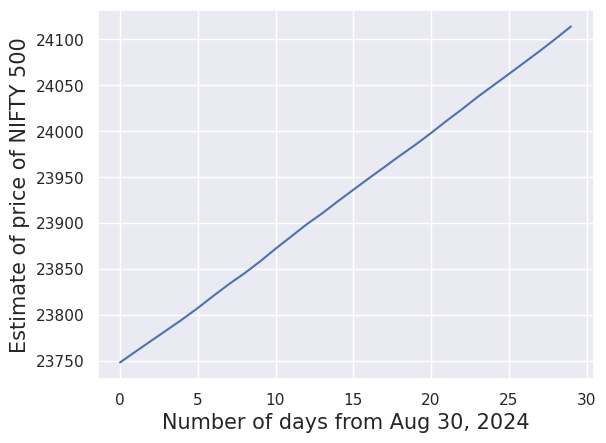

In [19]:
plt.plot(list(range(n)),avg)
plt.xlabel('Number of days from Aug 30, 2024', fontsize = 15)
plt.ylabel('Estimate of price of NIFTY 500', fontsize = 15)
plt.show()

# NIFTY Next 50

We run Monte Carlo Simulation for NIFTY Next 50.

In [20]:
mu = dfn50.PercentChange.mean()
s = dfn50["Volatility"].iloc[-1]
avg = [0]*(n)
price = []
for i in range(N):
    normals = rng.normal(size=n)
    prev_price = dfn50['Close'].iloc[-1]
    for j in range(n):
        p = prev_price + mu*prev_price + s*normals[j]*prev_price
        avg[j] = (avg[j]*i+p)/(i+1)
        prev_price = p
    price.append(prev_price)
print("Expected price of NIFTY Next 50 after",n,"trading days from Aug 30, 2024:",avg[-1])

Expected price of NIFTY Next 50 after 30 trading days from Aug 30, 2024: 77004.62623859222


We plot the histogram of the distribution of prices of NIFTY Next 50 as predicted by Monte Carlo simulation after $n$ days.

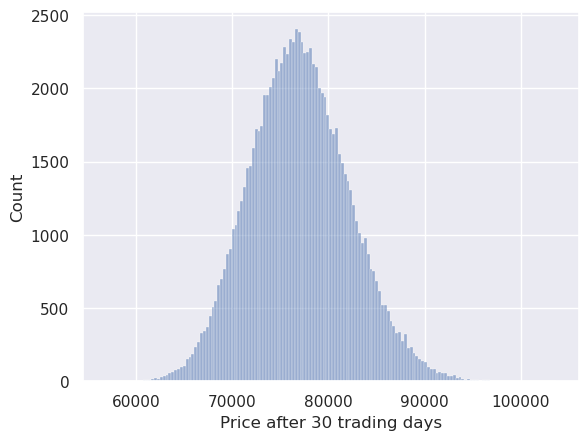

In [21]:
sns.histplot(pd.DataFrame(price),legend=False)
plt.xlabel("Price after "+str(n)+" trading days");
warnings.filterwarnings('ignore')

We plot the expected price of NIFTY Next 50 over the next $n$ days as predicted by Monte Carlo simulation.

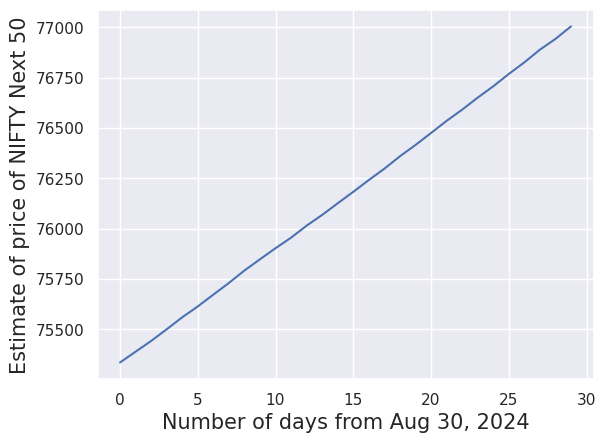

In [22]:
plt.plot(list(range(n)),avg)
plt.xlabel('Number of days from Aug 30, 2024', fontsize = 15)
plt.ylabel('Estimate of price of NIFTY Next 50', fontsize = 15)
plt.show()

# BSE 500

We run Monte Carlo Simulation for BSE 500.

In [23]:
mu = dfb500.PercentChange.mean()
s = dfb500["Volatility"].iloc[-1]
avg = [0]*(n)
price = []
for i in range(N):
    normals = rng.normal(size=n)
    prev_price = dfb500['Close'].iloc[-1]
    for j in range(n):
        p = prev_price + mu*prev_price + s*normals[j]*prev_price
        avg[j] = (avg[j]*i+p)/(i+1)
        prev_price = p
    price.append(prev_price)
print("Expected price of BSE 500 after",n,"trading days from Aug 30, 2024:",avg[-1])

Expected price of BSE 500 after 30 trading days from Aug 30, 2024: 38381.99008934461


We plot the histogram of the distribution of prices of BSE 500 as predicted by Monte Carlo simulation after $n$ days.

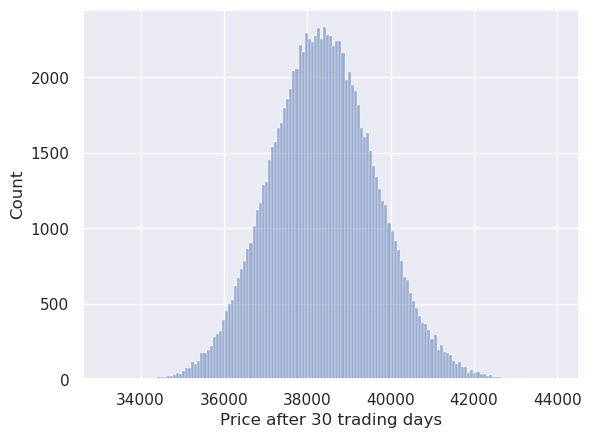

In [24]:
sns.histplot(pd.DataFrame(price),legend=False)
plt.xlabel("Price after "+str(n)+" trading days");
warnings.filterwarnings('ignore')

We plot the expected price of BSE 500 over the next $n$ days as predicted by Monte Carlo simulation.

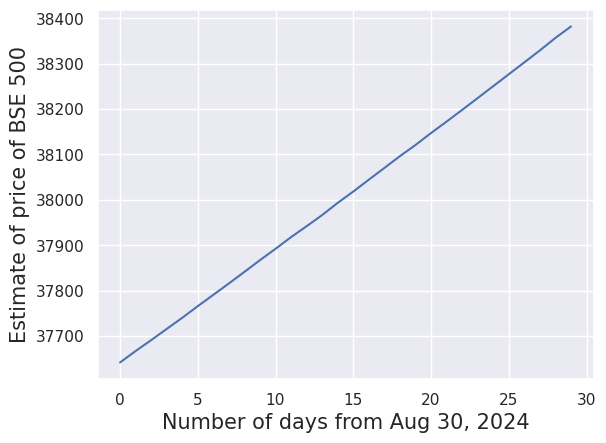

In [25]:
plt.plot(list(range(n)),avg)
plt.xlabel('Number of days from Aug 30, 2024', fontsize = 15)
plt.ylabel('Estimate of price of BSE 500', fontsize = 15)
plt.show()

# Alternate approach to Monte Carlo simulation

- If $S_i$ is the price of security on day i (and we fix $\mu$, $\sigma$), then we have
$$S_{i+1} = S_i e^{(\mu-\frac{1}{2}\sigma^2)+\sigma\epsilon}$$
- We start with $S_0$ as the last known price from historical data and run $N$ simulations to predict the price after $n$ days.
- As a demonstration, we do this for NIFTY 50 and compare with the results above.

In [26]:
mu = df50.PercentChange.mean()
s = df50["Volatility"].iloc[-1]
avg = [0]*(n)
price = []
for i in range(N):
    normals = rng.normal(size=n)
    prev_price = df50['Close'].iloc[-1]
    for j in range(n):
        p = prev_price*np.exp(mu-(s**2)/2 + s*normals[j])
        avg[j] = (avg[j]*i+p)/(i+1)
        prev_price = p
    price.append(prev_price)
print("Expected price of NIFTY 50 after",n,"trading days from Aug 30, 2024:",avg[-1])

Expected price of NIFTY 50 after 30 trading days from Aug 30, 2024: 25748.88235335543


We plot the histogram of the distribution of prices of NIFTY 50 as predicted by Monte Carlo simulation after $n$ days.

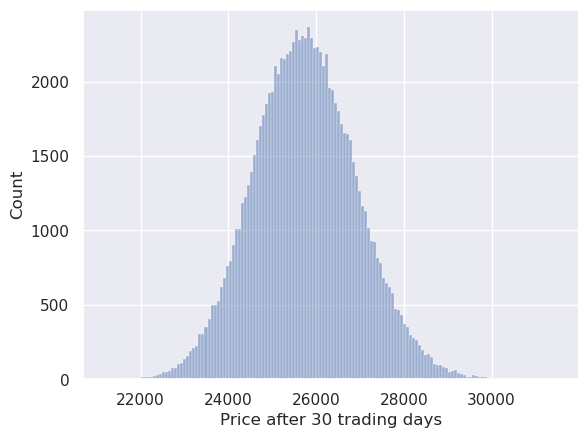

In [27]:
sns.histplot(pd.DataFrame(price),legend=False)
plt.xlabel("Price after "+str(n)+" trading days");
warnings.filterwarnings('ignore')

We plot the expected price of NIFTY 50 over the next $n$ days as predicted by Monte Carlo simulation.

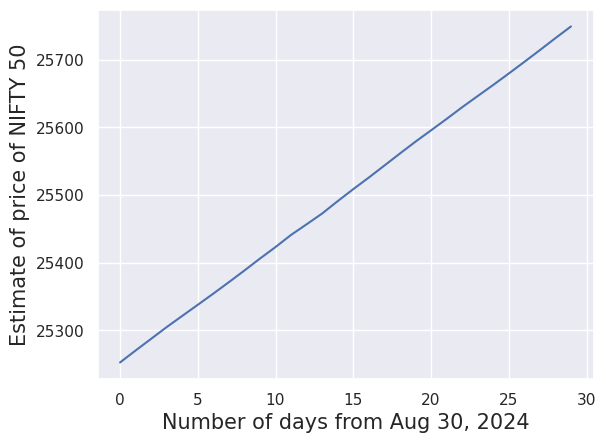

In [28]:
plt.plot(list(range(n)),avg)
plt.xlabel('Number of days from Aug 30, 2024', fontsize = 15)
plt.ylabel('Estimate of price of NIFTY 50', fontsize = 15)
plt.show()